In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

**Adjust the path to your project below**

In [ ]:
%run -n /path/to/your/projectrun.py
print(config['paramlist'])

## Check the config for this project

In [4]:
import os
figdir = os.path.join('figures_' +config['project_tag'])
try: 
    os.makedirs(figdir) 
except OSError as error: 
    print(error)   

    
template = figdir + '/fig_'+config['project_tag']+'_{:}.png'

In [47]:
print(config['project_tag'])

scan2D_example


**Adjust the path to your project below**

In [7]:
%load -s single_run,setup_run /path/to/your/project/run.py

# Plot Definitions

In [8]:
# %load ../scripts/cr_plot.py

from prince_analysis_tools.spectra import auger2015, auger2017, auger2019

def plot_cosmic_rays(result, deltaE=0., data=auger2015, data_label='Auger 2015'):
    import matplotlib.pyplot as plt
    from prince_cr.util import get_AZN
    
    A = lambda x: get_AZN(x)[0]

    for group, color, label, loffset in zip([(A,1,1),(A,2,4),(A,5,14),(A,15,28),(A,29,56)],
                                 ['red','gray','green','orange','blue'],
                                 [r'$\mathrm{A} = 1$',r'$2 \leq \mathrm{A} \leq 4$',r'$5 \leq \mathrm{A} \leq 14$',
                                  r'$15 \leq \mathrm{A} \leq 28$','$29 \leq \mathrm{A} \leq 56$'],
                                 [0, 0, 0 , 0, 0]):
#         if color == 'blue':
#             continue

        energy, spectrum = result.get_solution_group(group)
        energy *= 1 + deltaE
        l = plt.loglog(energy, spectrum, label=label, c=color, alpha = 0.6, lw=2)
        maxidx = spectrum.argmax()
        plt.annotate(label, (energy[maxidx+loffset], spectrum[maxidx+loffset] / 1.5),color=color, weight = 'bold', fontsize = 18,
                    horizontalalignment='center', verticalalignment='top')

    energy, spectrum = result.get_solution_group('CR')
    energy *= 1 + deltaE
    l = plt.loglog(energy, spectrum, c='saddlebrown',lw=2)

    plt.errorbar(data['energy'], data['spectrum'],
                 yerr=(data['lower_err'], data['upper_err']),
                 fmt='o', color='black', label = data_label,markersize=5)
    plt.annotate(data_label,(data['energy'][-4],data['spectrum'][-4]*1.5),fontsize=20,
                 horizontalalignment='left', verticalalignment='bottom')
#     plt.legend(ncol=1, loc='lower left', fontsize='small')

    plt.xlim(5e8,5e11)
    plt.ylim(1e0,1e3)

    plt.ylabel('E$^3$ J [GeV$^{2}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
    plt.xlabel('E [GeV]')

In [9]:
# %load ../scripts/xmax_plot.py
def make_error_boxes(xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.5):

    ax = plt.gca()
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import Rectangle

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

from prince_analysis_tools.xmax import XmaxSimple
from prince_analysis_tools.spectra import Xmax2015, Xmax2017, Xmax2019, XRMS2015, XRMS2017, XRMS2019

def plot_xmax_mean(result, deltaE = 0.,xshift=0.,
                   model=XmaxSimple(model=XmaxSimple.EPOSLHC),
                   data=Xmax2015, data_label=r'\langle Xmax \rangle Auger 2015'):

    egrid, average, variance = result.get_lnA([el for el in result.known_species if el >= 100])
    energy = egrid
    energy *= 1 + deltaE
    mean_lnA = average
    sigma_lnA = variance

    import matplotlib.pyplot as plt
    # plot the reference models
    for A, c, name in zip([1,4,14,56], ['red','gray','green','blue'],['H','He','N','Fe']):
        Xmax = model.get_mean_Xmax(np.log(A), energy)
        plt.semilogx(energy,Xmax, color = c, lw=2)
        idx = find_nearest(energy,1e11)
        plt.annotate(name,(energy[idx+1],Xmax[idx]),color = c,annotation_clip=False)

    Xmax = model.get_mean_Xmax(mean_lnA, energy)
    plt.semilogx(energy, Xmax, color = 'saddlebrown', ls ='solid',lw=2)

    xerr = np.array((data['energy_Low'], data['energy_Up']))
    yerr = np.array((data['sys_Low'], data['sys_Up']))
    make_error_boxes(data['energy'], data['val'], xerr, yerr, facecolor='gray')
    
    if xshift > 0:
        xcorr = xshift * data['sys_Up']
    else:
        xcorr = xshift * data['sys_Low']

    plt.errorbar(data['energy'], data['val'] + xcorr,
                 xerr=(data['energy_Low'], data['energy_Up']),
                 yerr=(data['stat'], data['stat']),
                 fmt='o',markersize=4, label=data_label, c='black')

    plt.xlim(1e9,1e11)
    plt.ylim(600,900)
    plt.xlabel('E  [GeV]')
    plt.ylabel(r'$\langle X_{max} \rangle$ [g cm$^{-2}$]')
    
def plot_xmax_sigma(result, deltaE = 0.,xshift=0.,
                    model=XmaxSimple(model=XmaxSimple.EPOSLHC),
                    data=XRMS2015, data_label=r'\langle Xmax \rangle Auger 2015'):
    
    egrid, average, variance = result.get_lnA([el for el in result.known_species if el >= 100])
    energy = egrid
    energy *= 1 + deltaE
    mean_lnA = average
    var_lnA = variance

    import matplotlib.pyplot as plt
    for A, c, name in zip([1,4,14,56], ['red','gray','green','blue'],['H','He','N','Fe']):
        sigmaXmax, sigmaXmax_part = np.sqrt(model.get_var_Xmax(np.log(A), 0., energy))
        plt.semilogx(energy,sigmaXmax, color = c,lw=2)
        idx = find_nearest(energy,1e11)
        plt.annotate(name,(energy[idx+1],sigmaXmax[idx]),color = c,annotation_clip=False)

    sigmaXmax, sigmaXmax_part = np.sqrt(model.get_var_Xmax(mean_lnA, var_lnA, energy))
    plt.semilogx(energy,sigmaXmax, color = 'saddlebrown', ls ='solid',lw=2)
#     plt.semilogx(energy,sigmaXmax_part, color = 'saddlebrown', ls ='dashed')

    xerr = np.array((data['energy_Low'], data['energy_Up']))
    yerr = np.array((data['sys_Low'], data['sys_Up']))
    make_error_boxes(data['energy'], data['val'], xerr, yerr, facecolor='gray')
    
    if xshift > 0:
        xcorr = xshift * data['sys_Up']
    else:
        xcorr = xshift * data['sys_Low']
    
    plt.errorbar(data['energy'], data['val'] + xcorr,
                 xerr=(data['energy_Low'], data['energy_Up']),
                 yerr=(data['stat'], data['stat']),
                 fmt='o',markersize=4, label='Xmax Auger 2015', c='black')
    
    plt.xlim(1e9,1e11)
    plt.ylim(0,70)
    plt.xlabel('E  [GeV]')
    plt.ylabel(r'$\sigma( X_{max})$ [g cm$^{-2}$]')

# Show scan summary

**Adjust the path to your project below**

In [10]:
from os import path
filepath = path.join('./','collected.hdf5')
input_spec = np.array(config['input_spec'])
# paramlist = tuple((key,value) for key,value in config['paramlist'].items())
paramlist = config['paramlist']

from prince_analysis_tools.plotter import ScanPlotter
scan = ScanPlotter(filepath, input_spec, paramlist)#, fit ='floating_E_Sibyll_2015')

prince_run = setup_run()
scan.comp_lum_frac(prince_run,pbar=True)
scan.print_summary()
#print(scan.get_comb_result(scan.minindex))
#print (scan.lum_fractions)

CUPY not found for GPU support. Degrading to MKL.



-----------------------------
| Summary:                  |
-----------------------------
('| Best fit chi2: ', 44.488638311788854)
('| at parameters: ', (-0.34999999999999987, 2818382931.264449, 0.0))
('| norm:          ', 2.7923263205614716e-45)
('| E-shift        ', 0.0)
('| xmax-shift     ', 0.0)
| fractions:     
| 101 with 4.97 %
| 402 with 90.71 %
| 1407 with 4.06 %
| 2814 with 0.26 %
('< 0.1 %:', [5626])
-----------------------------
| lum fractions:     
| 101 with 0.50 %
| 402 with 46.79 %
| 1407 with 39.91 %
| 2814 with 12.80 %
('< 0.1 %:', [5626])
-----------------------------


In [11]:
m, r = scan.recompute_fit(scan.minindex,minimizer_args={'print_level':0, 'fix_deltaE': True,},
                    spectrum_only=False, xmax_model='epos',dataset=2015)
print(m.fmin)
print(m.params)
print(m.args)
print(m.fval)

/afs/ifh.de/group/that/work-pavlo/anaconda3/lib/python3.8/site-packages/prince_cr/solvers/propagation.py:148: RuntimeWarning: invalid value encountered in true_divide
  average = (
/afs/ifh.de/group/that/work-pavlo/anaconda3/lib/python3.8/site-packages/prince_cr/solvers/propagation.py:150: RuntimeWarning: invalid value encountered in true_divide
  variance = (lnA[:, np.newaxis]**2 *


------------------------------------------------------------------
| FCN = 44.49                   |     Ncalls=770 (770 total)     |
| EDM = 3.09e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------
|   | Name       |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--

# Parameterspace Plots

In [12]:
smin_index = scan.minindex

<ipython-input-49-0461421b849b>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


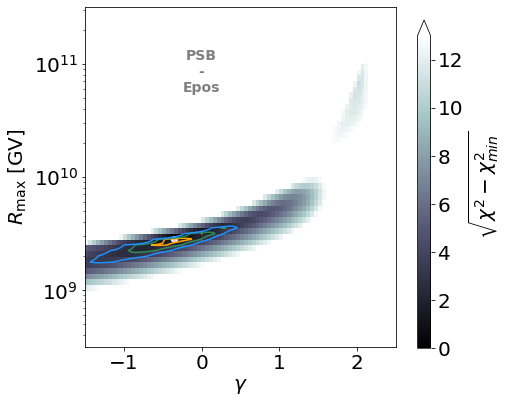

In [49]:
gamma, rmax, m = np.meshgrid(*scan.paramvalues,indexing='ij')
chi2marg = scan.chi2_array - scan.minchi2

from scipy.interpolate import RegularGridInterpolator as RGI

# intp = RGI(tuple(*scan.paramvalues),chi2marg)
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size':20})
contours = {
    'levels':[2.30,6.18,11.83], # m = 2
    'colors':['orange','seagreen','dodgerblue']
#     'colors':['purple','green','orange']

}

ax = plt.subplot(111)

pcm = plt.pcolormesh(gamma[:,:,0], rmax[:,:,0], np.sqrt(chi2marg).min(axis=2),cmap='bone',vmin=0.,vmax=13.)
con = plt.contour(gamma[:,:,0], rmax[:,:,0], chi2marg.min(axis=2),**contours)
sca = plt.scatter(gamma[scan.minindex],rmax[scan.minindex],c='white')
sca = plt.scatter(gamma[smin_index],rmax[smin_index],c='pink',marker='*')

plt.xlim(gamma.min(),gamma.max())
plt.ylim(rmax.min(),rmax.max())

# plt.xlim(1.,gamma.max())
# plt.ylim(1e10,rmax.max())

plt.semilogy()
plt.xlabel('$\gamma$')
plt.ylabel(r'$R_\mathrm{max}$ [GV]')

position = fig.add_axes([1,0.16,0.03,0.76])
plt.colorbar(pcm,cax=position, label=r'$\sqrt{\chi^2 - \chi^{2}_{min}}$',extend='max',)

plt.text(0.5,0.8,'PSB\n-\nEpos',color='gray',fontsize=14,
         transform=fig.transFigure, weight='semibold',
         horizontalalignment='center', 
         verticalalignment='center',)

plt.tight_layout()
plt.savefig(template.format('paramspace'), dpi=300)
plt.show()

# Example plots, best fit

In [42]:
def combine_results(results, fractions, norm):
    return np.sum([res * f for f, res in zip(fractions,results)]) * norm

/afs/ifh.de/group/that/work-pavlo/anaconda3/lib/python3.8/site-packages/prince_cr/solvers/propagation.py:148: RuntimeWarning: invalid value encountered in true_divide
  average = (
/afs/ifh.de/group/that/work-pavlo/anaconda3/lib/python3.8/site-packages/prince_cr/solvers/propagation.py:150: RuntimeWarning: invalid value encountered in true_divide
  variance = (lnA[:, np.newaxis]**2 *
/afs/ifh.de/group/that/work-pavlo/anaconda3/lib/python3.8/site-packages/prince_cr/solvers/propagation.py:148: RuntimeWarning: invalid value encountered in true_divide
  average = (
/afs/ifh.de/group/that/work-pavlo/anaconda3/lib/python3.8/site-packages/prince_cr/solvers/propagation.py:150: RuntimeWarning: invalid value encountered in true_divide
  variance = (lnA[:, np.newaxis]**2 *
<ipython-input-44-7e0f84a0ccb9>:19: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace

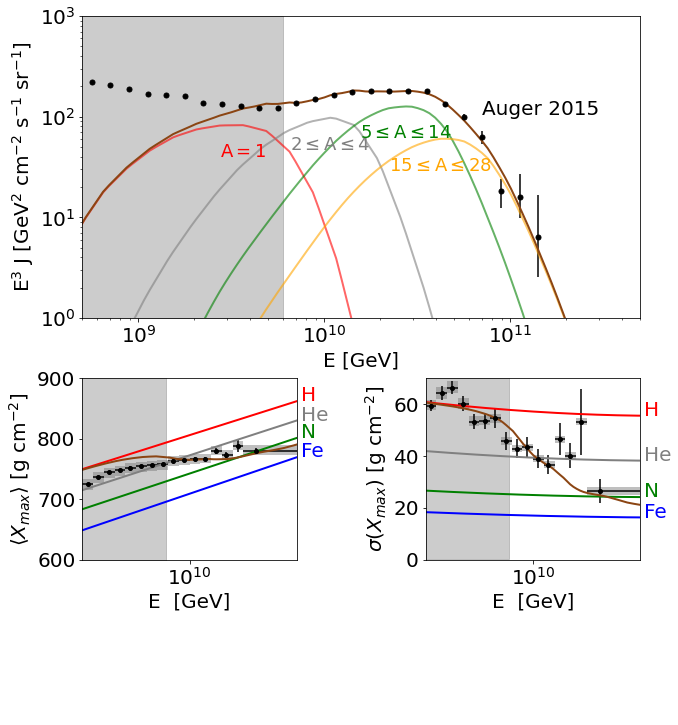

In [44]:
result = scan.get_comb_result(scan.minindex)
deltaE = scan.deltaE_array[scan.minindex]
xshift = scan.xshift_array[scan.minindex]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10),constrained_layout=True)

ax = plt.subplot2grid((5, 2), (0, 0), colspan=2,rowspan=3)
plot_cosmic_rays(result, deltaE = deltaE)
plt.fill_between([1e8,6e9],1e-1,1e3,color='gray', alpha = 0.4)
ax = plt.subplot2grid((5, 2), (3, 0), colspan=1,rowspan=2)
plot_xmax_mean(result, deltaE = deltaE, model=XmaxSimple(XmaxSimple.EPOSLHC))
plt.fill_between([1e8,6e9],1e-1,1e3,color='gray', alpha = 0.4)

ax = plt.subplot2grid((5, 2), (3, 1), colspan=1,rowspan=2)
plot_xmax_sigma(result, deltaE = deltaE, model=XmaxSimple(XmaxSimple.EPOSLHC))
plt.fill_between([1e8,6e9],1e-1,1e3,color='gray', alpha = 0.4)
plt.subplots_adjust(wspace=0.6, hspace=1)
#plt.tight_layout()
plt.savefig(template.format('bestfit_xrms'), dpi=400)
plt.show()

# Neutrinos from redshift 1

In [45]:
# m = 2
# exclude_idx exlcudes a single index (in this case there were numerical oscillations)
egrid, band1, _ = scan.comp_neutrino_band(chi_max=2.30,pbar=True)
egrid, band2, _ = scan.comp_neutrino_band(chi_max=6.18,pbar=True, exclude_idx = [(62, 23, 0)])
egrid, band3, _ = scan.comp_neutrino_band(chi_max=11.83,pbar=True)

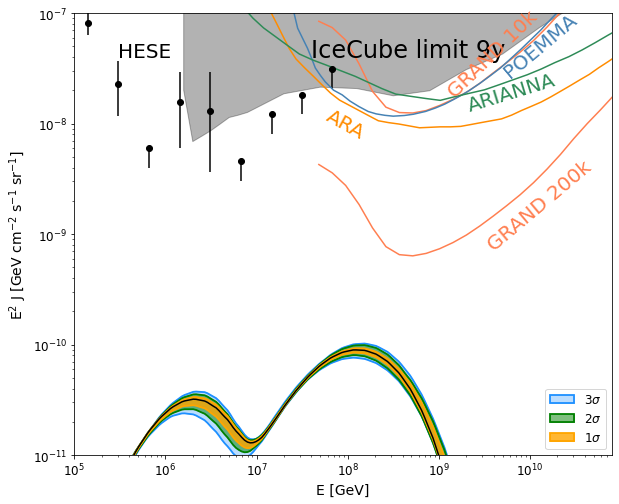

In [46]:
# best_fit
#lower bands
plt.figure(figsize=(9,7.5))

alpha = 0.3
handles=[]

alpha = 0.3
h1 = plt.fill_between(egrid, band3.min(axis = 0), band3.max(axis =0),
                 alpha = alpha, color = 'dodgerblue',label=r'$3 \sigma$')
h2 = plt.fill_between(egrid, band3.min(axis = 0), band3.max(axis =0),
                 alpha = 1., facecolor = 'none',edgecolor='dodgerblue',linewidth=1.8,linestyle='-')
handles.append((h1,h2))

alpha = 0.5
h1 = plt.fill_between(egrid, band2.min(axis = 0), band2.max(axis =0),
                 alpha = alpha, color = 'green',label=r'$2 \sigma$')
h2 = plt.fill_between(egrid, band2.min(axis = 0), band2.max(axis =0),
                 alpha = 1., facecolor = 'none',edgecolor='green',linewidth=1.8,linestyle='-')
handles.append((h1,h2))

alpha = 0.8
h1 = plt.fill_between(egrid, band1.min(axis = 0), band1.max(axis =0),
                 alpha = alpha, color = 'orange',label=r'$1 \sigma$')
h2 = plt.fill_between(egrid, band1.min(axis = 0), band1.max(axis =0),
                 alpha = 1, facecolor = 'none',edgecolor='orange',linewidth=1.8,linestyle='-')
handles.append((h1,h2))

res = scan.get_comb_result(scan.minindex)
egrid, spec = res.get_solution_group('nu',epow=2)
plt.loglog(egrid,spec,c='black',label='best fit')

from prince_analysis_tools.spectra import IClimit2017, IClimit2017GRB, IClimit9year
from prince_analysis_tools.spectra import IClimit9year_new as IClimit9year

plt.fill_between(IClimit9year['energy'], IClimit9year['limit'], np.ones_like(IClimit9year['energy']),
                 color='black',alpha= 0.3)
plt.annotate('IceCube limit 9y',(4e7,4e-8), fontsize = 'large')
# plt.loglog(IClimit9year['energy'], IClimit9year['limit'], color='black')

# from analyzer.spectra import GRAND200K, GRAND10K, ARA, ARIANNA, HESE, Poemma
# from analyzer.spectra import GRAND200K as GRAND200K_old
# from analyzer.spectra import ARIANNA as ARIANNA_old
# from analyzer.spectra import ARIANNA as ARIANNA_old

from prince_analysis_tools.spectra import GRAND200K_new as GRAND200K
from prince_analysis_tools.spectra import GRAND10K_new as GRAND10K
from prince_analysis_tools.spectra import POEMMA_new as Poemma
from prince_analysis_tools.spectra import ARA_new as ARA
from prince_analysis_tools.spectra import ARIANNA_new as ARIANNA
from prince_analysis_tools.spectra import HESE

plt.loglog(GRAND200K['energy'], GRAND200K['limit'], color='coral')
plt.annotate('GRAND 200k',(4e9,7e-10), fontsize = 'medium', color='coral', rotation=40, rotation_mode='anchor')

plt.loglog(GRAND10K['energy'], GRAND10K['limit'], color='coral')
plt.annotate('GRAND 10k',(1.5e9,1.7e-8), fontsize = 'medium', color='coral', rotation=44, rotation_mode='anchor')

plt.loglog(Poemma['energy'], Poemma['limit'], color='steelblue')
plt.annotate('POEMMA',(6e9,2.6e-8), fontsize = 'medium', color='steelblue', rotation=40, rotation_mode='anchor')

plt.loglog(ARA['energy'], ARA['limit'], color='darkorange')
plt.annotate('ARA',(5.6e7,1.1e-8), fontsize = 'medium', color='darkorange', rotation=-29, rotation_mode='anchor')

plt.loglog(ARIANNA['energy'], ARIANNA['limit'], color='seagreen')
plt.annotate('ARIANNA',(2.2e9,1.3e-8), fontsize = 'medium', color='seagreen', rotation=17, rotation_mode='anchor')

plt.errorbar(HESE['energy'].value, HESE['flux'].value,
             yerr=(HESE['lower_err'].value, HESE['upper_err'].value),
             fmt='o',c='black')
plt.annotate('HESE',(3e5,4e-8), fontsize = 'medium', color='black', rotation=0, rotation_mode='anchor')

# plt.xlim(IClimit2017['energy'][0].value,IClimit2017['energy'][-1].value)
# plt.xlim(IClimit2017['energy'][0].value,1e11)
plt.ylim(1e-11,1e-7)
plt.xlim(1e5,IClimit9year['energy'][-1].value)

plt.legend(loc='lower right')
plt.legend(handles,(r'$3 \sigma$',r'$2 \sigma$',r'$1 \sigma$'),loc='lower right',fontsize=12)

plt.ylabel('E$^2$ J [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]',fontsize=14)
plt.xlabel('E [GeV]',fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(template.format('neutrinos'), dpi=300)
plt.show()